In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from transformers import BertForSequenceClassification,BertModel
from imblearn.over_sampling import SMOTE
from utils import CLSdata,CLSdata2
import numpy as np
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"


These two codeblocks was used to debug the dataloader.

In [10]:




# csv_file = 'src/transformed/data.csv'
# npy_dir = 'src/embedded_ef/'

# dataset = CLSdata(csv_file=csv_file, npy_dir=npy_dir)
# # dataset = SimpleCLSdata(npy_dir=npy_dir)
# dataloader = DataLoader(dataset, batch_size=32, num_workers=0,shuffle=True)

# Fetch the first item
# errorlist = 0

# dataset.__getitem__(0)

# for i in range(0,100000,5):
#     try:
#         dataset.__getitem__(i)
#     except:
#         errorlist +=1
# print(f"{errorlist}/{1000000/5}")
# embed, label = dataset.__getitem__(1000)
# print(f"Embedding shape: {embed.shape}, Label: {label}")

In [11]:
n = 10
l = []

for i in range(20):
    l.append(np.load(f"data/embedded/embedded_text{i}.npy"))

In [12]:
del l

In [13]:
csv_file = 'data/transformed/data.csv'
npy_dir = 'data/embedded/'

dataset = CLSdata2(csv_file=csv_file, npy_dir=npy_dir)



# for i in tqdm(range(len(dataset))):
#     dataset[i]
# data_loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=1)


# for i in tqdm(data_loader,colour="red"):
#     pass
# for i in range(len(dataset)):
#     try:
#         dataset.__getitem__(i)
#     except Exception as e:
#         print("Index:",i)
#         print(e)

# tens.shape

In [14]:
print(len(dataset))

2355961


**We Must split the data first**

In [15]:
#Function for simple bootstrap aggregating

def bootstrap_samples(labels):
    labels_arr = np.array(labels)
    
    # Get indices of 0 and 1 values
    indices_0 = np.where(labels_arr == 0)[0]
    indices_1 = np.where(labels_arr == 1)[0]
    
    # Sample with replacement from 0 values
    sampled_indices_0 = np.random.choice(indices_0, size=len(indices_0), replace=True)
    
    # Sample without replacement from 1 values
    sampled_indices_1 = np.random.permutation(indices_1)
    
    # Combine sampled indices
    sampled_indices = np.concatenate([sampled_indices_0, sampled_indices_1])
    
    # Create the sampled list by selecting items from the original list based on combined sampled indices
    sampled_labels = labels_arr[sampled_indices]
    
    return sampled_labels, sampled_indices


labels = np.array(dataset.labels[:-2])
indices = np.arange(len(labels))

train_idx, temp_idx, train_labels, temp_labels = train_test_split(
    indices, labels, test_size=0.4, stratify=labels,shuffle=True,random_state=0)

samples = bootstrap_samples(train_labels)
print(sum(samples[0])/len(samples[0]))
# trainsamples

0.8987129813232672


In [16]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
labels = np.array(dataset.labels[:-2])
indices = np.arange(len(labels))
# Assuming X is your features and y is the labels
X_train, X_test, y_train, y_test = train_test_split(indices.reshape(-1,1), labels, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
X_test_res, y_test_res = smote.fit_resample(X_test, y_test)

In [18]:
y_train_res.sum() / len(y_train_res)

0.5

In [22]:
X_train_res
for i in X_train_res[:10]:
    dataset[int(i)]

Requesting item 1159166
Loading new file...
Requesting item 403914
Loading new file...
Requesting item 1308544
Loading new file...
Requesting item 1396405
Requesting item 2122607
Loading new file...
Requesting item 1028515
Loading new file...
Requesting item 1104529
Requesting item 1313179
Requesting item 1012006
Requesting item 1520465
Loading new file...


C:\Users\Jayden\AppData\Local\Temp\ipykernel_9156\1006166681.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dataset[int(i)]
c:\Users\Jayden\Documents\school\capstone\utils.py:122: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:212.)
  embed = torch.from_numpy(self.file_cache[file_idx][local_idx]).float()


In [10]:
#Basic model with no advanced implementations like dropout or batch norm
class Model1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(768,512)
        self.layer2 = nn.Linear(512,350)
        self.layer3 = nn.Linear(350,300)
        self.layer4 = nn.Linear(300,250)
        self.layer5 = nn.Linear(250,100)
        self.layer6 = nn.Linear(100,2)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        x = F.relu(self.layer5(x))
        return self.layer6(x)
        # return F.softmax(self.layer6(x),dim=0)


In [12]:

# Assuming Model1 is defined as per your snippet

# Initialize the model
model = Model1().to(device)

# Define your dataset
# Here you should load your dataset and prepare it
# For this example, let's assume we have a DataLoader that provides the entire dataset in one batch
# trainsubset = Subset(dataset,X_train_res)
# testsubset = Subset(dataset,X_test_res)
# data_loader = torch.utils.data.DataLoader(trainsubset, batch_size=30000)
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Initialize the optimizer
optimizer = optim.Adam(model.parameters())

# Define the number of epochs
epochs = 1

# Training loop
train_loss= []

for epoch in range(epochs):
    print(f"----- EPOCH {epoch} -----")
    epoch_loss = 0  # To accumulate loss over the epoch
    for idx, (inputs, labels) in enumerate(train_loader):
        print(labels)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs).squeeze()
        # print(f"Labels shape: {outputs.squeeze().shape}, Type: {outputs.dtype}")

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()
        print(f"\rBatch {idx}, Loss: {loss.item()}", end = "", flush = True)
        train_loss.append(loss)
    avg_epoch_loss = epoch_loss / len(data_loader)
    print(f"Epoch {epoch+1}, Avg Loss: {avg_epoch_loss}")

----- EPOCH 0 -----


NameError: name 'train_loader' is not defined

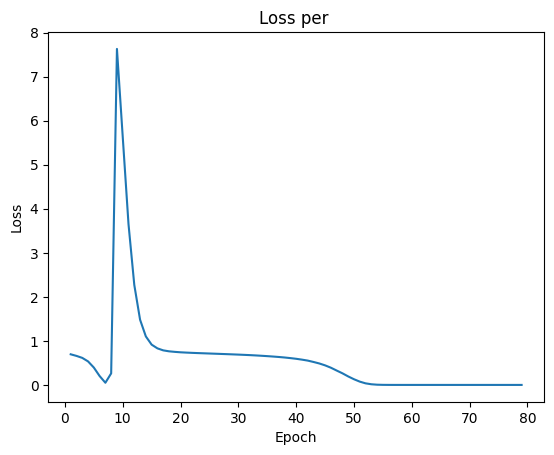

In [ ]:
plt.plot([*range(1,79+1)],[x.detach().numpy() for x in train_loss])
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.xticks([*range(1,77+1)])
plt.title("Loss per ")
plt.show()

In [ ]:
def accuracy(model, data_loader, device):
    with torch.no_grad():
        model = model.train()
        true_pred = 0
        tot_samples = 0
        for imgs, labels in data_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            logits = model(imgs)
            _, label_pred = torch.max(logits, axis=1)
            true_pred += (label_pred==labels).sum()
            tot_samples += labels.shape[0]
        acc = (true_pred/float(tot_samples))*100
    return acc

In [ ]:
torch.manual_seed(2)
random_seed = 1
batch_size = 128
learning_rate = 0.01
num_epochs = 20
num_classes = 10


model = Model()
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
#For storing data on losses
train_loss= []

start = time.time()
for epoch in range(num_epochs):
    model = model.train()
    for batch_idx, (imgs, labels) in enumerate(trainloader):
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        ## Forward Propagation - extract features and classify
        logits = model(imgs)
        loss = F.cross_entropy(logits, labels)
        
        #zero out the gradients
        optimizer.zero_grad()
        #estimate new gradients
        loss.backward()
        #update parameters
        optimizer.step()
        
        if not (batch_idx + 1) % 100:
            print(
                f"Epoch: {epoch + 1:03d}/{num_epochs:03d} | "
                f"Batch: {batch_idx + 1:03d}/{len(trainloader):03d} | "
                f"Loss: {loss:.4f}"
            )
    
    # Tracking the Learning Rate Scheduler
    prev_lr = optimizer.param_groups[0]["lr"]
    scheduler.step()
    current_lr = optimizer.param_groups[0]["lr"]
    print(f"Epoch: {epoch+1:03d} Learning Rate {prev_lr:.8f} -> {current_lr:.8f}")

    # Evaluate Performance after each epoch
    model = model.eval()
    tr_acc = accuracy(model, trainloader, device)
    valid_acc = accuracy(model, valid_loader, device)
    print(f"Train Accuracy: {tr_acc:0.3f}")
    print(f"Validation Accuracy: {valid_acc:0.3f}")
    print(f"Time elapsed so far: {(time.time() - start) / 60:.2f} min")
    train_loss.append(loss)
print(f"Total Train Time: {(time.time() - start) / 60:.2f} min")


------ Epoch 0 ------
Forward Pass


IndexError: index out of range in self